In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


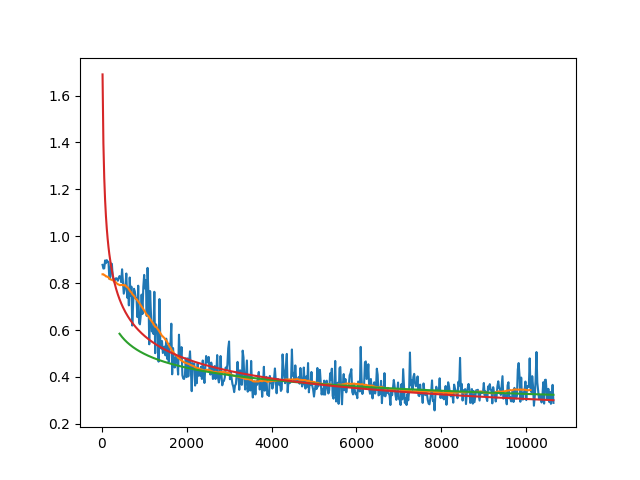

In [40]:


data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'jsons/val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 5e-4
patience = 10
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

# end = 150
# real_steps = steps[:end]
# real_val_err = val_err[:end]
# bnds = ((0, None), (None, 0), (0,None), (0, None))
# inits = (1,0,1,0)
# fun = lambda x: np.sum(np.power((real_val_err-(np.exp(x[1]*np.log(real_steps)+np.log(x[0]))+np.exp(x[3]*np.log(real_steps)+np.log(x[2])))),2))
# res = scipy.optimize.minimize(fun, inits, method='TNC', bounds=bnds)
# a = res.x[0]
# b = res.x[1]
# c = res.x[2]
# d = res.x[3]

# # plt.plot(steps, a*np.power(steps, b) + c*np.power(steps, d))
# print(a,b,c,d)
s = 1760 // num_epochs_between_eval
e = 5000 // num_epochs_between_eval
a, b = power_regression(steps[s:e], val_err[s:e], np.ones(e-s))
plt.plot(steps[20:], a*np.power(steps[20:], b))

s = 0 // num_epochs_between_eval
a, b = power_regression(steps[s:e], val_err[s:e], np.ones(e-s))
plt.plot(steps, a*np.power(steps, b))

In [23]:
smoothed_steps = (np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval

start1 = 100
end1 = 500
start2 = start1
end2 = start2+50

zs = []
p_values = []
slope1, intercept1, r_value, p_value, std_err1 = \
                scipy.stats.linregress(smoothed_steps[start1:end1],val_err[start1:end1])
std_err1 = np.std(val_err[start1:end1] - slope1*smoothed_steps[start1:end1]+intercept1)/(np.sqrt(end1-start1) * np.std(smoothed_steps[start1:end1]))
for end2 in range(end1, 4000, 20):
#     end2 = start2 + 50
    start2 = end2 - 500
    slope2, intercept2, r_value, p_value, std_err2 = \
                    scipy.stats.linregress(smoothed_steps[start2:end2],val_err[start2:end2])
    numerator = slope1 - slope2
    
    std_err2 = np.std(val_err[start2:end2] - slope2*smoothed_steps[start2:end2]+intercept2)/(np.sqrt(end2-start2) * np.std(smoothed_steps[start2:end2]))
    denominator = pow((pow(std_err1,2) + pow(std_err2,2)), 1/2)
    z = numerator / denominator
    p_value = scipy.stats.norm.sf(abs(z))*2
    print(end2,z, p_value)
    
    zs.append(z)
    p_values.append(p_value)

plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)
plt.plot(smoothed_steps[:end1], slope1*smoothed_steps[:end1]+intercept1)
plt.plot(smoothed_steps[:end2], slope2*smoothed_steps[:end2]+intercept2)
plt.figure()
plt.semilogy(num_epochs_between_eval*(np.arange(end1, 4000, 20)+1), p_values, '-o')



500 14.443162517453652 2.7684221327832983e-47
520 11.122251691172721 9.777273558946114e-29
540 6.951477211681266 3.6148081015097954e-12
560 2.4113788952573154 0.015892328780994926
580 -0.43733077261607284 0.6618714814146865
600 -2.9205577684717228 0.0034940541194527987
620 -4.23475847201095 2.287974850263912e-05


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
a = 2.1296990908675575
b = -0.17078869800251614
var = 0.00047153359673779487
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
y = a*np.power(steps,b)
noise = np.random.normal(0, np.sqrt(var), len(steps))
x = y + noise

smoothed_x = smooth_by_linear_filter(x, smooth_win_size)

plt.figure()
plt.plot(steps, y)
plt.plot(steps, x)
plt.plot(smoothed_steps, smoothed_x)

var_est = np.var(x[50:100]-smoothed_x[50:100])
print(var_est)
# plt.semilogx(steps, x)

In [5]:
def LAD(steps, y):
    fun = lambda x: np.sum(np.abs(y-(x[0]*steps+x[1])))
    res = scipy.optimize.minimize(fun, (0,1), method='Nelder-Mead', bounds=((None,None),(None,None)))
    a = res.x[0]
    b = res.x[1]
    
    return a,b

def interpolation(steps, values, num_inters):
    rst_steps = []
    rst_values = []
    for i in range(len(steps)-1):
        rst_steps.append(steps[i])
        rst_values.append(values[i])
        for j in range(num_inters):
            rst_steps.append((steps[i+1]*(j+1)+steps[i]*(num_inters-j))/(num_inters+1))
            rst_values.append((values[i+1]*(j+1)+values[i]*(num_inters-j))/(num_inters+1))
    
    rst_steps.append(steps[-1])
    rst_values.append(values[-1])
    return rst_steps, rst_values
            

<IPython.core.display.Javascript object>


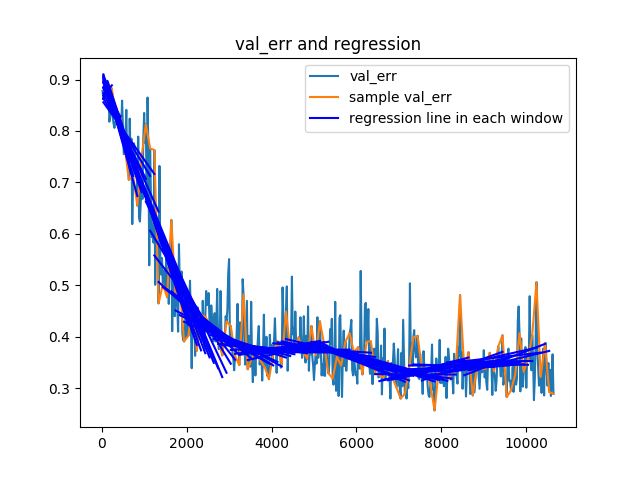

<IPython.core.display.Javascript object>


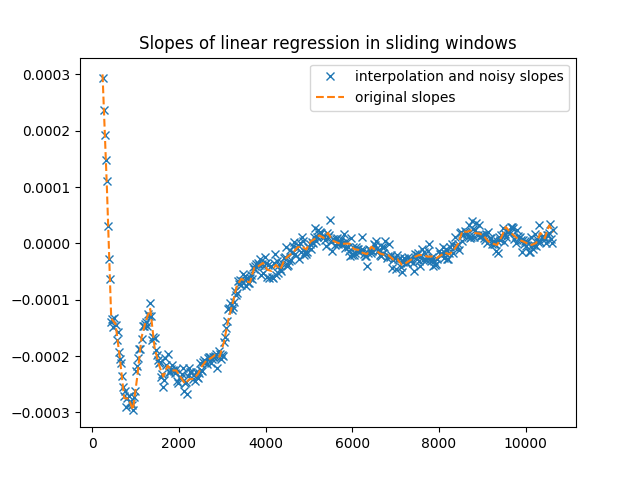

<IPython.core.display.Javascript object>


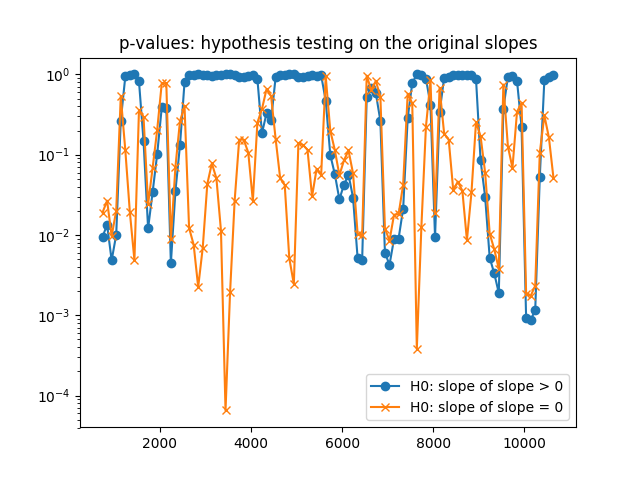

<IPython.core.display.Javascript object>


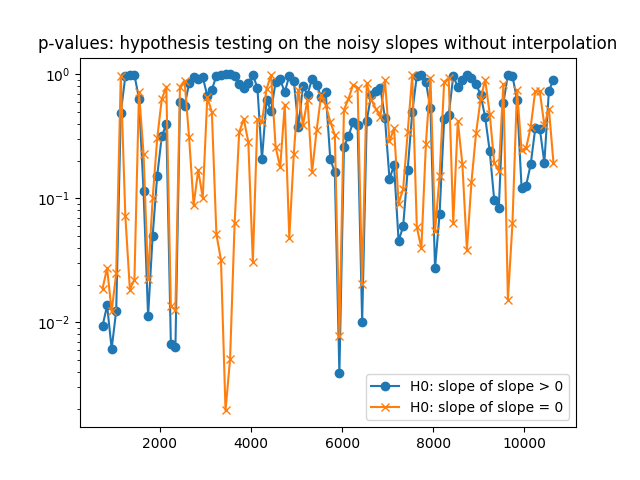

<IPython.core.display.Javascript object>


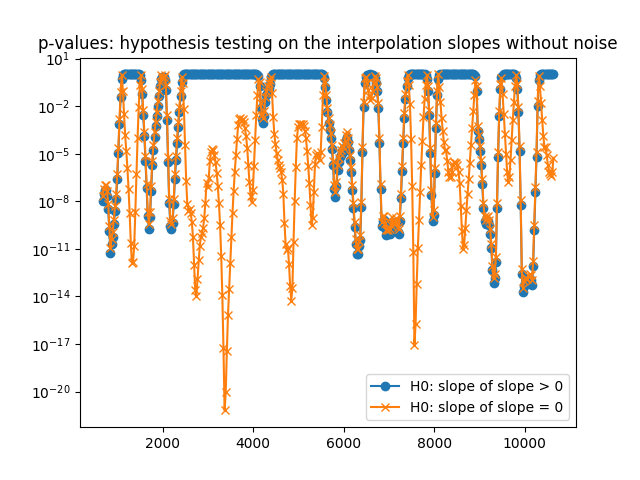

1790.0
2690.0

4090.0
4990.0


<IPython.core.display.Javascript object>


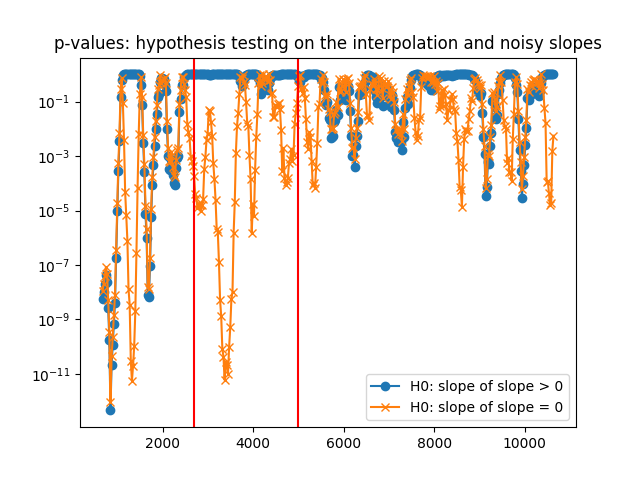

In [35]:
data_file = 'jsons/cifar_subset_train_summary_1.json'
with open(data_file) as f:
    dict_ = json.load(f)

# eval_err = dict_['eval_err']
# eval_epochs = dict_['eval_epochs']
err = np.array(dict_['eval_err'])
steps = np.array(dict_['eval_epochs'])

##############################################################
data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'jsons/val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

smooth_win_size = 1
sample_size = 5
err = 1 - np.array(val_acc)
# smooth_err = smooth_by_linear_filter(err, smooth_win_size)
sample_err = err[range(1,len(err),sample_size)]
num_epochs_between_eval = 20
steps = (np.arange(len(err)) + 1)*num_epochs_between_eval
# smooth_steps = (np.arange(len(smooth_err)) + 1)*num_epochs_between_eval
sample_steps = steps[range(1,len(steps),sample_size)]
#################################################################
# val_err and the regression line in each window
plt.figure()
plt.plot(steps, err)
# plt.plot(smooth_steps, smooth_err)
plt.plot(sample_steps, sample_err)

err = sample_err
steps = sample_steps
regression_win_size = 100 // sample_size
slopes = []
rst_steps = []
for end in range(10//sample_size, len(steps), 5//sample_size):
    start = max(end - regression_win_size,0)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(steps[start:end],err[start:end])
    slopes.append(slope)
    plt.plot(steps[start:end], slope*steps[start:end]+intercept, 'b')
    rst_steps.append(steps[end])
plt.legend(['val_err', 'sample val_err','regression line in each window'])
plt.title('val_err and regression')
##################################################################

#################################################################
# slope of regression line in each sliding window
# doing interpolation and adding noise on the curve
plt.figure()
var = 1e-10

noise_rst_steps, interpolation_slopes = interpolation(rst_steps, slopes, 3)
noise = np.random.normal(0, np.sqrt(var), len(interpolation_slopes))
noise_slopes = interpolation_slopes + noise
plt.plot(noise_rst_steps, noise_slopes, 'x')
plt.plot(rst_steps, slopes, '--')
plt.legend(['interpolation and noisy slopes', 'original slopes'])
plt.title('Slopes of linear regression in sliding windows')
#################################################################

#################################################################
# hypothesis testing on the original slopes
num_points = 5
start = num_points
threshold = 9e-1
p_values = []
p_values2 = []
co = 0
max_co = 10
flag = True
for i in range(start,len(rst_steps)):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(rst_steps[i-num_points:i],slopes[i-num_points:i])
#     print(rst_steps[i], std_err, abs(slope)/std_err, p_value)
    p_values2.append(p_value)
    t_value = slope / std_err
    p_value = scipy.stats.t.cdf(t_value, df=num_points-2)
    p_values.append(p_value)
#     if flag:
#         if p_value > threshold:
#             co += 1
#         if co >= max_co:
#             print(rst_steps[i-co-num_points+1])
#             flag = False


plt.figure()
plt.semilogy(rst_steps[start:], p_values, '-o')
plt.semilogy(rst_steps[start:], p_values2, '-x')
plt.legend(['H0: slope of slope > 0','H0: slope of slope = 0'])
plt.title('p-values: hypothesis testing on the original slopes')
#################################################################

#################################################################
# hypothesis testing on the noisy slopes without interpolation
noise = np.random.normal(0, np.sqrt(var), len(slopes))
noise_slopes = slopes + noise

p_values = []
p_values2 = []
num_points = 5
start = num_points
for i in range(start,len(rst_steps)):
    slope, intercept, r_value, p_value2, std_err = scipy.stats.linregress(rst_steps[i-num_points:i],noise_slopes[i-num_points:i])
    p_values2.append(p_value2)
    t_value = slope / std_err
    p_value = scipy.stats.t.cdf(t_value, df=num_points-2)
    p_values.append(p_value)
    
plt.figure()
plt.semilogy(rst_steps[start:], p_values, '-o')
plt.semilogy(rst_steps[start:], p_values2, '-x')
plt.legend(['H0: slope of slope > 0','H0: slope of slope = 0'])
plt.title('p-values: hypothesis testing on the noisy slopes without interpolation')
#################################################################

#################################################################
# hypothesis testing on the interpolation slopes without adding noise
noise_rst_steps, interpolation_slopes = interpolation(rst_steps, slopes, 3)
noise = np.random.normal(0, np.sqrt(var), len(interpolation_slopes))
noise_slopes = interpolation_slopes + noise

p_values = []
p_values2 = []
num_points = 17
start = num_points
for i in range(start,len(noise_rst_steps)):
    slope, intercept, r_value, p_value2, std_err = scipy.stats.linregress(noise_rst_steps[i-num_points:i],interpolation_slopes[i-num_points:i])
    p_values2.append(p_value2)
    t_value = slope / std_err
    p_value = scipy.stats.t.cdf(t_value, df=num_points-2)
    p_values.append(p_value)
    
plt.figure()
plt.semilogy(noise_rst_steps[start:], p_values, '-o')
plt.semilogy(noise_rst_steps[start:], p_values2, '-x')
plt.legend(['H0: slope of slope > 0','H0: slope of slope = 0'])
plt.title('p-values: hypothesis testing on the interpolation slopes without noise')
#################################################################

#################################################################
# interpolation and noisy slopes
p_values = []
p_values2 = []
num_points = 17
start = num_points
co = 0
max_co = 20 
flag = True
num_outlier_epochs = 0
flag2 = True
co2 = 0
max_co2 = 20
threshold2 = 1e-1
threshold3 = 1e-2
double_check_epoch = 1000
double_chech_threshold = 1e-6
for i in range(start,len(noise_rst_steps)):
    slope, intercept, r_value, p_value2, std_err = scipy.stats.linregress(noise_rst_steps[i-num_points:i],noise_slopes[i-num_points:i])
    p_values2.append(p_value2)
    t_value = slope / std_err
    p_value = scipy.stats.t.cdf(t_value, df=num_points-2)
    p_values.append(p_value)
    if flag:
        if p_value > threshold and p_value2 < threshold3 and noise_rst_steps[i-co2-num_points+1] > num_outlier_epochs:
            co += 1
        if co >= max_co:
            t1_delay = noise_rst_steps[i]
            t1 = noise_rst_steps[i-co-num_points+1]
            print(t1)
            print(t1_delay)
            flag = False
    if not flag and noise_rst_steps[i-co-num_points+1] - double_check_epoch < t1 and p_value < double_chech_threshold:
        flag = True
        co = 0
        
    if flag2 and flag == False:
        if p_value2 > threshold2:
            co2 += 1
        if co2 >= max_co2:
            t2_delay = noise_rst_steps[i]
            t2 = noise_rst_steps[i-co2-num_points+1]
            print('\n{}'.format(t2))
            print(t2_delay)
            flag2 = False

plt.figure()
plt.semilogy(noise_rst_steps[start:], p_values, '-o')
plt.semilogy(noise_rst_steps[start:], p_values2, '-x')
plt.legend(['H0: slope of slope > 0','H0: slope of slope = 0'])
plt.title('p-values: hypothesis testing on the interpolation and noisy slopes')
plt.axvline(x=t1_delay, color='r')
plt.axvline(x=t2_delay,color='r')

# print(noise_rst_steps)

In [ ]:
num_points = 1000
x = np.arange(num_points) 
slope1 = 0.0005
slope2 = 0.0003

# original
y1 = slope1*x
y2 = slope2*x

f, power1 = scipy.signal.welch(y1,nperseg=256)
f, power2 = scipy.signal.welch(y2,nperseg=256)
plt.figure()
plt.plot(f,power1)
plt.plot(f,power2)
plt.xlim(-0.005,0.2)
plt.title('Energy Spectrum: no noise')
plt.legend(['larger slope', 'smaller slope'])

# adding small noise
var = 0.001
noise = np.random.normal(0, np.sqrt(var), num_points)
yn1 = y1 + noise
noise = np.random.normal(0, np.sqrt(var), num_points)
yn2 = y2 + noise
f, power_n1 = scipy.signal.welch(yn1,nperseg=256)
f, power_n2 = scipy.signal.welch(yn2,nperseg=256)
plt.figure()
plt.plot(f,power_n1)
plt.plot(f,power_n2)
plt.xlim(-0.005,0.2)
plt.title('Energy Spectrum: adding small noise')
plt.legend(['larger slope', 'smaller slope'])


# adding proper noise
var = 0.015
noise = np.random.normal(0, np.sqrt(var), num_points)
yn1 = y1 + noise
noise = np.random.normal(0, np.sqrt(var), num_points)
yn2 = y2 + noise
f, power_n1 = scipy.signal.welch(yn1,nperseg=256)
f, power_n2 = scipy.signal.welch(yn2,nperseg=256)
plt.figure()
plt.plot(f,power_n1)
plt.plot(f,power_n2)
plt.xlim(-0.005,0.2)
plt.title('Energy Spectrum: adding proper noise')
plt.legend(['larger slope', 'smaller slope'])

# adding large noise
var = 0.1
noise = np.random.normal(0, np.sqrt(var), num_points)
yn1 = y1 + noise
noise = np.random.normal(0, np.sqrt(var), num_points)
yn2 = y2 + noise
f, power_n1 = scipy.signal.welch(yn1,nperseg=256)
f, power_n2 = scipy.signal.welch(yn2,nperseg=256)
plt.figure()
plt.plot(f,power_n1)
plt.plot(f,power_n2)
plt.xlim(-0.005,0.2)
plt.title('Energy Spectrum: adding large noise')
plt.legend(['larger slope', 'smaller slope'])

# plt.figure()
# plt.plot(x,noise)

In [ ]:
data_file = 'jsons/cifar_subset_train_summary_1.json'
with open(data_file) as f:
    dict_ = json.load(f)

# eval_err = dict_['eval_err']
# eval_epochs = dict_['eval_epochs']
err = np.array(dict_['eval_err'])[1:]
steps = np.array(dict_['eval_epochs'])[1:]

plt.figure()
plt.plot(steps, err)

end = 381
print(steps[end])
steps = steps[:end]
err = err[:end]
weights = np.ones(len(steps))
co = 11
for i in range(200,331,10):
    weights[i:i+10] = co
    co -= 1
for i in range(147,200,10):
    weights[i:i+10] = co
    co += 1
print(co)
# weights = np.ones_like(steps)
a,b = power_regression(steps, err, weights)
plt.plot(steps, power_function(steps,a,b))
a = 6.283088740148172
b = -0.3506429646203036
d=6.620476679888371e-05
plt.plot(steps, power_function(steps,a,b))

print(steps[331])

residual = err - power_function(steps,a,b)

plt.figure()
linear_steps = steps[331:]
residual = residual[331:]
plt.plot(linear_steps, residual)

al,bl = linear_regression(linear_steps, residual)
plt.plot(linear_steps, al*linear_steps+bl)
print(al)

index = 331
bnds = ((0, None), (None, 0), (0, None))
inits = (1,0,0)
fun = lambda x: np.sum(np.power((err[:index]-(np.exp(x[1]*np.log(steps[:index])+np.log(x[0]))))*weights[:index], 2)) \
                + np.sum(np.power((err[index:]-(np.exp(x[1]*np.log(steps[index:])+np.log(x[0]))+x[2]*(steps[index:]-steps[index])))*weights[index:], 2))
res = scipy.optimize.minimize(fun, inits, method='TNC', bounds=bnds)
a = res.x[0]
b = res.x[1]
# d = res.x[2]

plt.plot(steps[index:], d*(steps[index:]-steps[index]))